The Hill transformation formula:
y = α × x^β / (x^β + θ^β)

where:
	• y = predicted response (Revenue)
	• x = spend (Digital_Spend in this case)
	• α = alpha - maximum achievable revenue (plateau)
	• β = beta - steepness of the curve
	• θ = theta - spend value where the effect is half of the maximum

    hill(x, alpha, beta, theta): implements Hill transformation formula
    y = alpha * (x**beta) / (x**beta + theta**beta)
    alpha = max (plateau), beta = steepness, theta = half-saturation spend

   curve_fit(): SciPy fitting interface that calls the hill() function repeatedly
   Uses an internal optimizer (e.g., Trust Region Reflective) to find the
   alpha, beta, theta values that minimize squared error between predicted and actual y.
   p0: initial guesses for parameters (starting point for optimizer)
   bounds: allowed parameter range (keeps optimizer within valid limits)
   Example: p0=[max(y),1,np.median(x)]
            bounds=([0,0,0],[np.inf,10,np.inf])

In [4]:
from typing import Annotated
import sys
import os
from typing_extensions import TypedDict, Literal
from langgraph.graph import MessagesState  # Add this import
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import AzureChatOpenAI
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
from langgraph_playground.multiagent_framework.utils import *
from azure.search.documents import SearchClient
from langchain_core.runnables import RunnableConfig
import logging
from langchain_core.tools import tool
import json
from langchain_core.messages import ToolCall
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver
from azure.ai.projects import AIProjectClient
from databricks_langchain.genie import GenieAgent
from databricks.sdk import WorkspaceClient
from databricks_ai_bridge.genie import  Genie, GenieResponse
from operator import add

# Install: pip install -U "psycopg[binary,pool]" langgraph langgraph-checkpoint-postgres

from langgraph.checkpoint.postgres import PostgresSaver
from langgraph.store.postgres import PostgresStore
from langgraph.store.base import BaseStore
from langchain_core.runnables import RunnableConfig
import uuid
from langmem.short_term import RunningSummary  # Add this import
import psycopg  # Add this import

c:\source\github\gen-ai-prototypes\.venv\Lib\site-packages\pydantic\_internal\_config.py:323: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)
c:\source\github\gen-ai-prototypes\.venv\Lib\site-packages\databricks_ai_bridge\vector_search_retriever_tool.py:107: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  @validator("tool_name")
c:\source\github\gen-ai-prototypes\.venv\Lib\site-packages\trustcall\_base.py:46: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constant

In [5]:
# Single-channel Hill fit: Digital_Spend -> Revenue (plateau behavior)
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# --- Actual-looking data (spend $k, revenue $k)
df = pd.DataFrame({
    "Digital_Spend": [10, 20, 30, 40, 50, 60, 70,  80,  90, 100, 110, 120],
    "Revenue":       [95, 150, 205, 250, 285, 305, 318, 325, 330, 334, 336, 337]
})

# Hill transformation
"""
The Hill transformation formula:
y = α × x^β / (x^β + θ^β)
where:
	• y = predicted response (Revenue)
	• x = spend (Digital_Spend in this case)
	• α = alpha - maximum achievable revenue (plateau)
	• β = beta - steepness of the curve
	• θ = theta - spend value where the effect is half of the maximum

    hill(x, alpha, beta, theta): implements Hill transformation formula
    y = alpha * (x**beta) / (x**beta + theta**beta)
    alpha = max (plateau), beta = steepness, theta = half-saturation spend

   curve_fit(): SciPy fitting interface that calls the hill() function repeatedly
   Uses an internal optimizer (e.g., Trust Region Reflective) to find the
   alpha, beta, theta values that minimize squared error between predicted and actual y.
   p0: initial guesses for parameters (starting point for optimizer)
   bounds: allowed parameter range (keeps optimizer within valid limits)
   Example: p0=[max(y),1,np.median(x)]
            bounds=([0,0,0],[np.inf,10,np.inf])

"""

def hill(x, alpha, beta, theta):
    x = np.asarray(x, dtype=float)
    x = np.clip(x, 1e-9, None)  # guard tiny x
    return alpha * (x**beta) / (x**beta + theta**beta)

# Ensure data is numpy array of floats
x = df["Digital_Spend"].to_numpy(float)
y = df["Revenue"].to_numpy(float)

# --- Scale to 0-1 help the optimizer
x_max, y_max = x.max(), y.max()
x_s, y_s = x / x_max, y / y_max

# --- Fit with sensible p0 and bounds
p0     = [1.05, 1.0, 0.5]                 # alpha≈plateau, beta≈1, theta≈mid-range (scaled)
bounds = ([0.0, 0.0, 0.0], [5.0, 10.0, 5.0])

params_s, _ = curve_fit(hill, x_s, y_s, p0=p0, bounds=bounds, maxfev=50000)
alpha_s, beta, theta_s = params_s

# --- Rescale params back to original units
alpha = alpha_s * y_max       # plateau (revenue units)
theta = theta_s * x_max       # half-saturation spend (spend units)

print(f"alpha (plateau)        = {alpha:.2f}  # max revenue")
print(f"beta (steepness)       = {beta:.3f}   # curve slope/shape")
print(f"theta (half-sat spend) = {theta:.2f}  # spend where ~50% of alpha is reached")

# --- Predict function (original units)
def predict_revenue(spend):
    return hill(spend, alpha, beta, theta)

# Examples
for s in [30, 60, 100, 140]:
    print(f"Predicted Revenue at ${s}k spend: {predict_revenue(s):.1f}k")


alpha (plateau)        = 383.45  # max revenue
beta (steepness)       = 1.414   # curve slope/shape
theta (half-sat spend) = 25.21  # spend where ~50% of alpha is reached
Predicted Revenue at $30k spend: 215.2k
Predicted Revenue at $60k spend: 296.5k
Predicted Revenue at $100k spend: 335.6k
Predicted Revenue at $140k spend: 352.3k


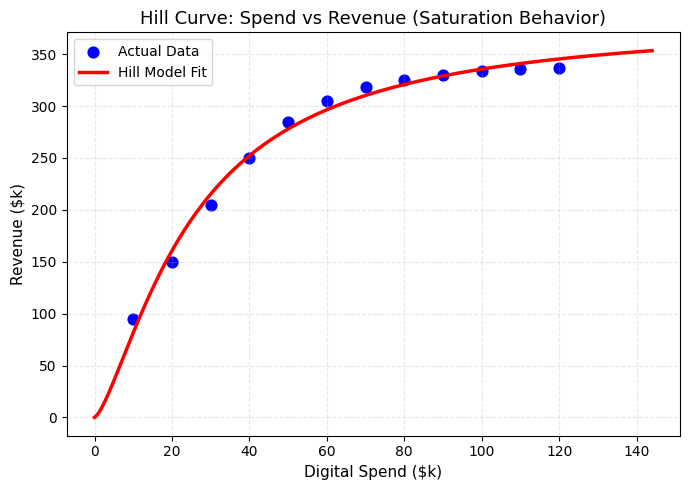

In [6]:
import matplotlib.pyplot as plt

# --- Visualizer
x_line = np.linspace(0, max(x) * 1.2, 200)   # smooth spend range for curve
y_line = predict_revenue(x_line)              # Hill curve

plt.figure(figsize=(7,5))
plt.scatter(x, y, color='blue', s=60, label='Actual Data')
plt.plot(x_line, y_line, color='red', linewidth=2.5, label='Hill Model Fit')
plt.xlabel("Digital Spend ($k)", fontsize=11)
plt.ylabel("Revenue ($k)", fontsize=11)
plt.title("Hill Curve: Spend vs Revenue (Saturation Behavior)", fontsize=13)
plt.grid(alpha=0.3, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()

### Residuals and Validation

R^2=0.990  MAE=6.66  RMSE=58.34


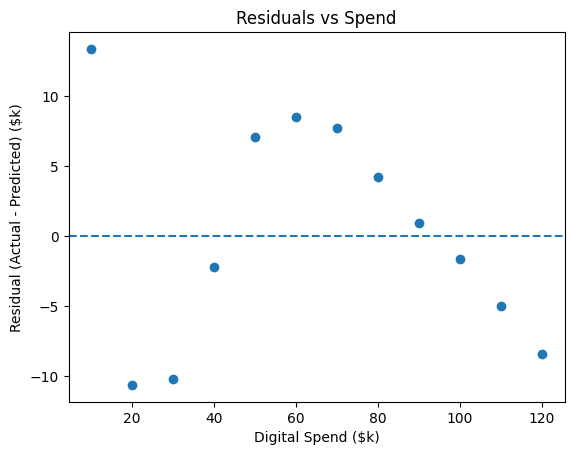

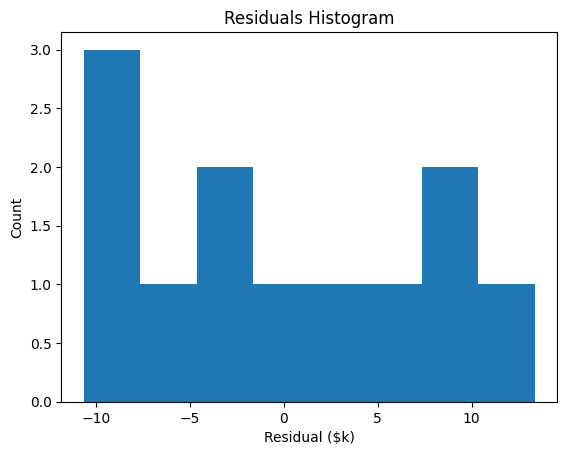

In [7]:
# --- Residuals & diagnostics (paste after your visualization code)

"""
Model Fit Metrics Summary
--------------------------
R² (R-squared): Fraction of variance in Revenue explained by the model.
    Range: 0 ≤ R² ≤ 1  (closer to 1 = better fit)
    1.0 → perfect fit; 0.0 → no explanatory power.

MAE (Mean Absolute Error): Average absolute difference between actual and predicted Revenue.
    Range: 0 ≤ MAE < ∞  (closer to 0 = better)
    Interpreted in same units as Revenue (e.g., $k).

RMSE (Root Mean Squared Error): Like MAE but penalizes large errors more heavily.
    Range: 0 ≤ RMSE < ∞  (closer to 0 = better)
    RMSE ≥ MAE; large gap implies presence of large outliers.

Ideal fit → High R², Low MAE, Low RMSE.
"""


from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# 1) Compute residuals on observed data
y_pred = predict_revenue(x)
resid = y - y_pred

# 2) Quick metrics
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
rmse = mean_squared_error(y, y_pred)
print(f"R^2={r2:.3f}  MAE={mae:.2f}  RMSE={rmse:.2f}")

# 3) Residuals vs Spend (should look like random noise around 0)
plt.figure()
plt.scatter(x, resid)
plt.axhline(0, linestyle="--")
plt.xlabel("Digital Spend ($k)")
plt.ylabel("Residual (Actual - Predicted) ($k)")
plt.title("Residuals vs Spend")
plt.show()

# 4) Residuals distribution (quick sanity check)
plt.figure()
plt.hist(resid, bins=8)
plt.xlabel("Residual ($k)")
plt.ylabel("Count")
plt.title("Residuals Histogram")
plt.show()


In [8]:
from typing import Annotated, Literal, Optional
from operator import add

from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import AzureChatOpenAI
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.types import Command
from pydantic import BaseModel

# Model configuration
# instantiate the chatbot model
routing_llm = AzureChatOpenAI(
    model="gpt-4o",
    api_key=azure_openai_api_key,
    api_version="2024-12-01-preview",
    azure_endpoint=azure_openai_endpoint,
    temperature=0.5
)

class AgentState(MessagesState):
    next: Optional[str] = None
    routed_intent: Annotated[list[str], add]
    spend_k: Optional[float] = None

class RouteDecision(BaseModel):
    target: Literal["Predictor", "FINISH"]
    reason: str
    spend_k: Optional[float] = None  # spend expressed in thousands of dollars

routing_prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessage(
            content=(
                "You supervise a marketing assistant.\n"
                "Respond with JSON containing `target`, `reason`, and `spend_k`.\n"
                "`target` must be `Predictor` when the user asks for revenue based on digital spend, otherwise `FINISH`.\n"
                "`spend_k` must be the numeric digital spend in thousands of dollars.\n"
                "Examples:\n"
                "- \"10k\" -> 10.0\n"
                "- \"10,000 dollars\" -> 10.0\n"
                "- \"0.5 million\" -> 500.0\n"
                "If no spend amount is stated, set `spend_k` to null."
            )
        ),
        ("user", "{query}"),
    ]
)

routing_chain = routing_prompt | routing_llm.with_structured_output(RouteDecision)

def _select_next(state: AgentState) -> str:
    return state.get("next", "FINISH")

from pydantic import ValidationError

def supervisor_node(state: AgentState):
    last_human = next(msg for msg in reversed(state["messages"]) if isinstance(msg, HumanMessage))
    try:
        decision = routing_chain.invoke({"query": last_human.content})
    except ValidationError as exc:
        # Fallback: finish gracefully and surface the issue
        error_msg = AIMessage(content=f"Routing failed to parse: {exc}")
        return Command(
            update={
                "next": "FINISH",
                "messages": [error_msg],
                "routed_intent": ["routing_error"],
                "spend_k": None,
            }
        )

    supervisor_note = AIMessage(
        content=f"Supervisor routing to {decision.target}: {decision.reason}"
    )
    return Command(
        update={
            "next": decision.target,
            "spend_k": decision.spend_k,
            "routed_intent": [decision.reason],
            "messages": [supervisor_note],
        }
    )

def predictor_node(state: AgentState):
    spend_k = state.get("spend_k")
    if spend_k is None:
        reply = "I couldn’t detect a spend amount. Please specify an approximate digital spend (e.g., 10k)."
    else:
        est_revenue = predict_revenue(spend_k)
        reply = (
            f"Spending about ${spend_k:.1f}k on digital is expected to deliver roughly "
            f"${est_revenue:.1f}k in revenue based on the Hill model."
        )

    return Command(
        update={
            "messages": [AIMessage(content=reply)],
            "next": "FINISH",
        }
    )

graph = StateGraph(AgentState)
graph.add_node("supervisor", supervisor_node)
graph.add_node("Predictor", predictor_node)
graph.add_edge(START, "supervisor")
graph.add_conditional_edges("supervisor", _select_next, {"Predictor": "Predictor", "FINISH": END})
graph.add_edge("Predictor", END)

multi_agent = graph.compile()

# Example query
result = multi_agent.invoke({"messages": [HumanMessage(content="What if I spend about 10k dollars on digital?")]})
print(result["messages"][-1].content)

Spending about $10.0k on digital is expected to deliver roughly $81.6k in revenue based on the Hill model.
